In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import pearsonr, spearmanr
import gtfparse


intron_annot = pd.read_csv('/project2/yangili1/bjf79/ChromatinSplicingQTLs/data/IntronAnnotationsFromYang.tsv.gz', sep='\t')
intron_annot['junction'] = intron_annot[['chrom', 'start', 'end', 'strand']].astype(str).agg(':'.join, axis=1)
long_table = pd.read_csv(
    '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
)

long_table = long_table.loc[long_table.RepNumber == '1.junc'].drop_duplicates()
long_table = long_table.loc[~((long_table.IndID == 'NA18855') & (long_table.Dataset == 'chRNA.Expression.Splicing'))]

# Adjustment needed to match the introns in Yang's annotation...
long_table.stop += 1

long_table = long_table.merge(intron_annot, left_on=['chrom', 'start', 'stop', 'strand'], 
                 right_on=['chrom', 'start', 'end', 'strand'])

long_table['gene'] = [x.split('.')[0] for x in long_table.gene]

del intron_annot
expressed_genes = pd.read_csv('../code/ExpressionAnalysis/polyA/ExpressedGeneList.txt', sep ='\t',
                             names = ['chrom', 'start', 'end', 'gene', 'score', 'strand'])

expressed_genes.gene = [x.split('.')[0] for x in expressed_genes.gene]

In [2]:
long_table = long_table.loc[long_table.Dataset == 'chRNA.Expression.Splicing']

gene_total = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.sum()).reset_index()
gene_total.columns = ['gene', 'IndID', 'gene_total']

gene_max = pd.DataFrame(long_table.groupby(['gene', 'IndID']).Count.max()).reset_index()
gene_max.columns = ['gene', 'IndID', 'gene_max']

long_table = long_table.merge(gene_total, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']).merge(
    gene_max, left_on=['gene', 'IndID'], right_on=['gene', 'IndID']
)

long_table['PSI_total'] = long_table.Count/long_table.gene_total
long_table['PSI'] = long_table.Count/long_table.gene_max


In [3]:
long_table = long_table.loc[long_table.gene.isin(expressed_genes.gene)]

NMD = ['AnnotatedJunc_UnproductiveCodingGene', 'UnannotatedJunc_UnproductiveCodingGene']
PC = ['AnnotatedJunc_ProductiveCodingGene', 'UnannotatedJunc_ProductiveCodingGene']



In [4]:
RPKM = pd.read_csv(
    '../code/QTLs/QTLTools/chRNA.Expression.Splicing/OnlyFirstRepsUnstandardized.qqnorm.bed.gz', sep='\t',
                   index_col=3)
RPKM.index = [x.split('.')[0] for x in RPKM.index]

log2RPKM = RPKM[RPKM.columns.intersection(pd.Index(long_table.IndID.unique()))].median(axis=1).reset_index()
log2RPKM.columns = ['gene', 'RPKM']

In [5]:
nmd_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby('gene').Count.sum())

idx = nmd_counts.index

pc_counts = pd.DataFrame(
    long_table.loc[long_table.SuperAnnotation.isin(PC)].groupby('gene').Count.sum()).reindex(idx).fillna(0)


psi = (nmd_counts.Count/(pc_counts.Count + nmd_counts.Count))

In [6]:
exon_counts = pd.read_csv('../code/exons.appris_principal.basic_annotation.bed.gz', sep='\t')
exon_counts.columns = ['chrom', 'start', 'end', 'gene', 'symbol', 'strand', 'transcript']
exon_counts.gene = [x.split('.')[0] for x in exon_counts.gene]
exon_counts['exon_count'] = 1

In [7]:
from scipy.stats import entropy

long_summary = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'junction']).Count.sum().reset_index()
# long_summary = long_summary.merge(pd.DataFrame(
#     exon_counts.groupby(['gene', 'transcript']).exon_count.sum().reset_index().groupby('gene').exon_count.max()
# ), left_on='gene', right_index=True)

idx = psi.index

rank_list = []
gene_list = []
suma_list = []
intron_counts_list = []
entropy_list = []

count = 0
for gene, df in tqdm(long_summary.groupby('gene')):
    
    if gene not in idx:
        continue
    
    suma = int(nmd_counts.loc[gene].Count)
    
    suma_list.append(suma)
    
#     intron_counts = list(df.exon_count)[0]
#     intron_counts_list.append(intron_counts)

    rank_percent = df.sort_values('Count', ascending=False).Count/suma
    
    entropy_ = entropy(rank_percent)
    entropy_list.append(entropy_)
    
    rank_percent = sorted(rank_percent)[::-1]
    
    rank = []
    for i in range(5):
        if i >= len(rank_percent):
            to_add = 0
        elif i == 4:
            to_add = np.sum(rank_percent[4:])
        else:
            to_add = rank_percent[i]
        
        rank.append(to_add)
    rank_list.append(rank)
    gene_list.append(gene)
        
    
df_rank = pd.DataFrame(rank_list)
df_rank.columns = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']
df_rank.index = gene_list

df_summary = pd.DataFrame([suma_list, entropy_list]).T
df_summary.columns = ['total_reads', 'entropy']
df_summary.index = gene_list

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11586/11586 [00:07<00:00, 1566.23it/s]


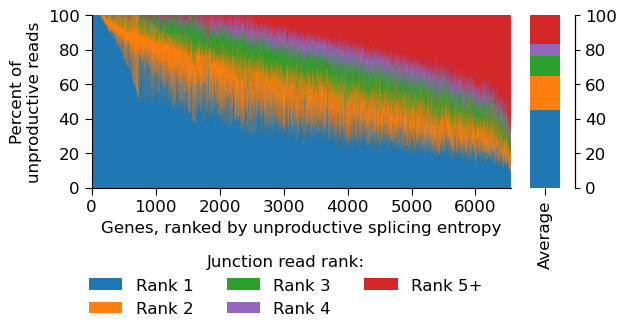

In [18]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6.24, 2.24), gridspec_kw={'width_ratios': [7, 1], 
                                                                       'wspace': 0.02})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.01)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = 100*df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by unproductive splicing entropy', size=12)
ax[0].set_ylabel('Percent of\nunproductive reads', size=12)

ax[0].set_ylim([0, 100])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 100])

# ax[1].set_xlim([-0.25, 0.25])

# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# ax[1].set_ylabel('Average percent of\nunproductive reads', size=12)

ax[1].set_xticklabels(['Average'])

ax[1].set_yticks([])
ax[1].legend(bbox_to_anchor=(-0.3, -0.3), frameon=False, title = 'Junction read rank:', fontsize=12, ncols=3)

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)

y = ax[1].secondary_yaxis('right')
y.set_ticks([0, 20, 40, 60, 80, 100], ['0', '20', '40', '60', '80', '100'], fontsize=12)


fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Read_ranks.100reads_1_to_20_percent_NMD.png', dpi=300, bbox_inches='tight',)

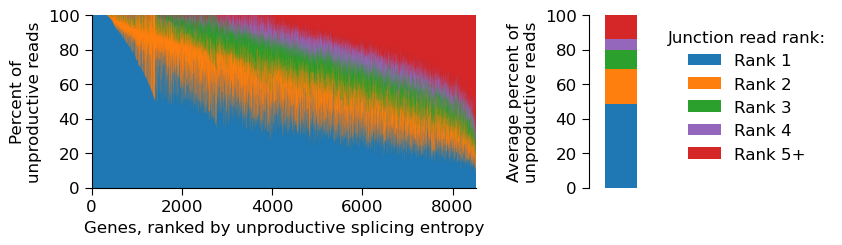

In [10]:
plt.rcParams['legend.title_fontsize'] = 12

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7.24, 2.24), gridspec_kw={'width_ratios': [6, 1], 
                                                                       'wspace': 0.5})

log_ = log2RPKM.loc[log2RPKM.index.intersection(df_rank.index)]

cutoff = psi.loc[(psi <= 0.2) & (psi >= 0.001)].index

top_quartile = nmd_counts.loc[nmd_counts.Count >= 100].index.intersection(df_rank.index).intersection(cutoff)

rank_ = df_rank.loc[top_quartile].sum(axis=1).sort_values()

df_idx = rank_.index

i = 0

df_rank_ = 100*df_rank.divide(df_rank.sum(axis=1), axis=0)

entropy_idx = df_summary.loc[df_idx].sort_values('entropy').index


for idx, row in df_rank_.loc[entropy_idx].iterrows():
    ax[0].plot([i, i], [0, row['Rank 1']], c='tab:blue', linewidth=0.2)
    ax[0].plot([i, i], [row['Rank 1'], 
                      row['Rank 2']+row['Rank 1']], c='tab:orange',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 2']+row['Rank 1'], 
                      row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:green',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:purple',
            linewidth=0.2)
    
    ax[0].plot([i, i], [row['Rank 4'] + row['Rank 3']+row['Rank 2']+row['Rank 1'], 
                      row['Rank 5+'] + row['Rank 4']+row['Rank 3']+row['Rank 2']+row['Rank 1']], c='tab:red',
            linewidth=0.2)
    
    i+=1
    
ax[0].set_xlabel('Genes, ranked by unproductive splicing entropy', size=12)
ax[0].set_ylabel('Percent of\nunproductive reads', size=12)

ax[0].set_ylim([0, 100])
ax[0].set_xlim([0, i])
ax[1].set_ylim([0, 100])


# sns.despine(ax=ax[0], offset=0, trim=True)

ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

pd.DataFrame(df_rank_.loc[df_idx].mean(axis=0)).T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'], ax=ax[1])

ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

ax[1].set_ylabel('Average percent of\nunproductive reads', size=12)

ax[1].set_xticks([])
ax[1].legend(bbox_to_anchor=(1, 1), frameon=False, title = 'Junction read rank:', fontsize=12)

ax[0].tick_params(length=5, labelsize=12)
ax[1].tick_params(length=5, labelsize=12)


fig_dir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(fig_dir + 'Read_ranks.100reads_0.1_to_20_percent_NMD.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'Read_ranks.100reads_0.1_to_20_percent_NMD.png', dpi=300, bbox_inches='tight',)

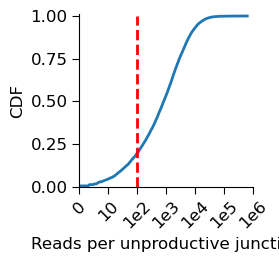

In [17]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

x = np.linspace(np.log10(long_summary.groupby('gene').Count.sum()).min(), 
                np.log10(long_summary.groupby('gene').Count.sum()).max(), 100)
y = [(np.log10(long_summary.groupby('gene').Count.sum()) <= z).mean() for z in x]
ax.plot(x, y, linewidth=2)
ax.set_xlabel('Reads per unproductive junction', size=12)
ax.set_ylabel('CDF', size=12)
# plt.xlim([-1, 51])
ax.set_xticks(range(7))
ax.set_xticklabels(['0', '10', '1e2', '1e3', '1e4', '1e5', '1e6'], size=12, rotation=45)
ax.plot([2, 2], [0, 1], 'r--', linewidth=2)
ax.set_xlim([0, 6])
ax.set_ylim([0, 1.01])
ax.tick_params(length=5, labelsize=12)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(fig_dir + 'NMD_reads_per_junction.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(fig_dir + 'NMD_reads_per_junction.png', dpi=300, bbox_inches='tight',)

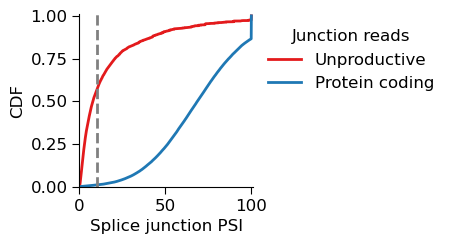

In [18]:
long_table_sum = long_table.groupby(['gene', 'symbol', 'junction', 'NewAnnotation', 'SuperAnnotation']
                                   ).Count.sum().reset_index()

gene_total_sum = pd.DataFrame(long_table_sum.groupby(['gene']).Count.max()).reset_index()
gene_total_sum.columns = ['gene',  'gene_max']

long_table_sum = long_table_sum.merge(gene_total_sum, left_on='gene', right_on='gene')
long_table_sum['PSI'] = long_table_sum.Count/long_table_sum.gene_max

long_table_sum_NMD = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(NMD)]
long_table_sum_PC = long_table_sum.loc[long_table_sum.SuperAnnotation.isin(PC)]
x = np.linspace(0, 1, 1001)
contribution_NMD = [long_table_sum_NMD.loc[long_table_sum_NMD.PSI <= y].Count.sum() for y in x]
contribution_PC = [long_table_sum_PC.loc[long_table_sum_PC.PSI <= y].Count.sum() for y in x]

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.plot(x*100, np.array(contribution_NMD)/np.max(contribution_NMD), label='Unproductive', c='#e31a1c', linewidth=2)
ax.plot(x*100, np.array(contribution_PC)/np.max(contribution_PC), label='Protein coding', c='#1f78b4', linewidth=2)
ax.plot([10, 10], [0, 100], linestyle='--', c='gray', linewidth=2)
ax.set_xlabel('Splice junction PSI', size=12)
ax.set_ylabel('CDF', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=12, title = 'Junction reads')

ax.set_xlim([0, 101])
ax.set_ylim([0, 1.01])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(length=5, labelsize=12)

plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.pdf', dpi=300, bbox_inches='tight')
plt.savefig(fig_dir + 'NMD_junction_reads_per_gene_CDF.png', dpi=300, bbox_inches='tight')

In [19]:
long_table_PSI = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(
    ['gene', 'symbol', 'junction']).PSI.mean().reset_index().groupby(['gene', 'symbol']).PSI.max().reset_index()

NMD_counts = long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'symbol']).Count.sum().reset_index()
NMD_counts.columns = ['gene', 'symbol', 'NMD_counts']
junc_counts = long_table.groupby(['gene', 'symbol']).Count.sum().reset_index()
junc_counts.columns = ['gene', 'symbol', 'junc_counts']

junc_counts = junc_counts.merge(NMD_counts, left_on=['gene', 'symbol'], right_on=['gene', 'symbol'])
junc_counts['NMD_percent'] = junc_counts.NMD_counts/junc_counts.junc_counts

In [20]:
NMD_by_gene = long_table_PSI.merge(junc_counts, left_on=['gene', 'symbol'], right_on=['gene', 'symbol']).merge(
log2RPKM, left_on='gene', right_on='gene').merge(df_rank, left_on='gene', right_index=True)

NMD_by_gene['TPM'] = 1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM))
NMD_by_gene['logTPM'] = np.log2(1e6*np.exp(NMD_by_gene.RPKM)/np.sum(np.exp(NMD_by_gene.RPKM)))
NMD_by_gene['NMD_transcripts'] = NMD_by_gene.TPM*NMD_by_gene.PSI



In [21]:
transcription_factors = []
splicing_factors = []
translation = []
histone_activity = []
rbps = []
with open('../../c5.all.v2023.1.Hs.symbols.gmt') as fh:#open('../../c5.go.bp.v2023.1.Hs.symbols.gmt') as fh:
    for line in fh:
        line = line.rstrip().split('\t')
        if (line[0][:5] == 'GOBP_') and (('TRANSCRIPTION_FACTOR' in line[0]) or ('TRANSCRIPTION_INITIATION' in line[0]) or ('TRANSCRIPTION_ELONGATION' in line[0])):
            transcription_factors.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and (('SPLICING' in line[0]) or ('SPLICE_SITE' in line[0])):
            splicing_factors.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and ((('HISTONE' in line[0]) or ('_CHROMATIN_ORGANIZATION' in line[0]) or ('_CHROMATIN_REMODELING' in line[0]))):
            histone_activity.extend(line[2:])
        elif (line[0][:5] == 'GOBP_') and (('TRANSLATION' in line[0])):
            translation.extend(line[2:])
        elif ('GOMF_RNA_BINDING' in line[0]):
            rbps.extend(line[2:])
        
            
transcription_factors = sorted(set(transcription_factors))
splicing_factors = sorted(set(splicing_factors))
translation = sorted(set(translation))
histone_activity = sorted(set(histone_activity))
rbps = sorted(set(rbps))

annotation = []
for gene in NMD_by_gene.symbol:
    if gene in transcription_factors:
        annotation.append('Transcription factors')
    elif gene in splicing_factors:
        annotation.append('Splicing factors')
#     elif gene in kinases:
#         annotation.append('Kinases')
    elif gene in translation:
        annotation.append('Translation factors')
    elif gene in histone_activity:
        annotation.append('Chromatin factors')
#     elif gene in rbps:
#         annotation.append('Other RBP')
    else:
        annotation.append('Other')
        
NMD_by_gene['annotation'] = annotation

In [22]:
scores = pd.read_csv('../../media-1.tsv', sep='\t', index_col=0)

genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(pd.Index(NMD_by_gene.gene))

NMD_by_gene = NMD_by_gene.merge(scores, left_on='gene', right_index=True)

In [23]:
ranks = ['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5+']

In [24]:
NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Splicing factors'), ranks].mean(axis=0)

Rank 1     0.487582
Rank 2     0.220994
Rank 3     0.111872
Rank 4     0.063277
Rank 5+    0.116275
dtype: float64

In [25]:
NMD_by_gene_selected = NMD_by_gene#.loc[NMD_by_gene.gene.isin(entropy_idx)]

def get_slice(df, i, step=0.1, attribute='NMD_transcripts'):
    qi = df[attribute].quantile(i)
    qi0 = df[attribute].quantile(i-step)
    df_counts = df.loc[(df[attribute] <= qi) & (df[attribute] >= qi0)]['annotation'].value_counts()
    df_frac = pd.DataFrame(df_counts/1).T
    df_frac.index = ['Q' + str(int((i/step)))]
    return df_frac

In [26]:
top_genes = NMD_by_gene_selected.loc[
    (NMD_by_gene_selected.RPKM > NMD_by_gene_selected.RPKM.quantile(0.75)) & (
    NMD_by_gene_selected.post_mean > NMD_by_gene_selected.post_mean.quantile(0.75))]

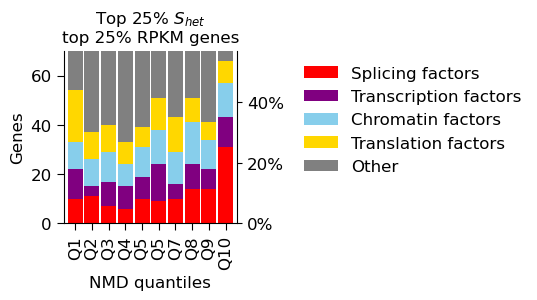

In [42]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Translation factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'gold', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,70])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot.png', dpi=300, bbox_inches='tight',)

In [43]:
top_genes.loc[top_genes.annotation=='Splicing factors', 'Rank 5+'].mean()

0.0642276979814627

In [46]:
top_genes.loc[top_genes.annotation=='Transcription factors', 'Rank 5+'].mean()

0.12061048447008049

In [47]:
df_bar = pd.DataFrame()
df_bar['All genes'] = top_genes.loc[top_genes.gene.isin(entropy_idx), 
                                             ranks].mean(axis=0)

df_bar['Splicing factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)
df_bar['Transcription factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Transcription factors'), 
                                             ranks].mean(axis=0)
df_bar['Chromatin factors'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Chromatin factors'), 
                                             ranks].mean(axis=0)
df_bar['Other'] = top_genes.loc[top_genes.gene.isin(entropy_idx) & (top_genes.annotation=='Other'), 
                                             ranks].mean(axis=0)

<Axes: >

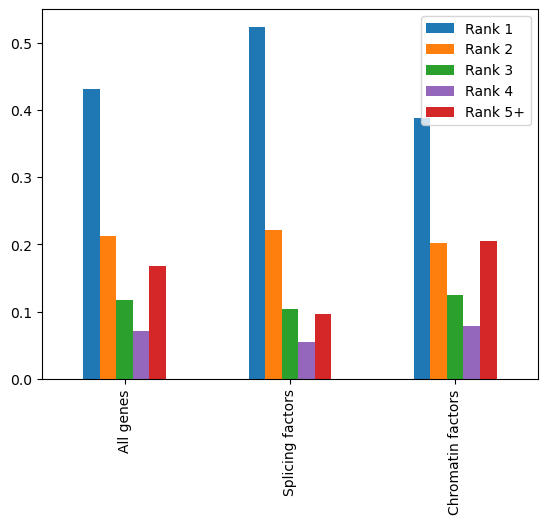

In [49]:
df_bar[['All genes', 'Splicing factors', 'Chromatin factors']
      ].T.plot(kind='bar', stacked=False, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'])


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

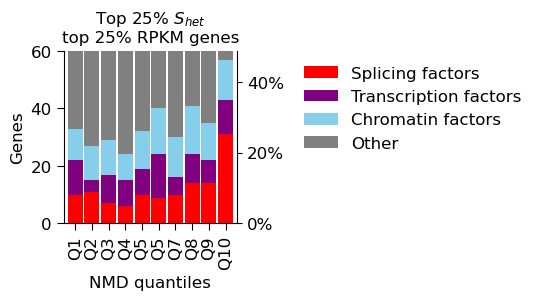

In [145]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1) for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,60])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot.png', dpi=300, bbox_inches='tight',)

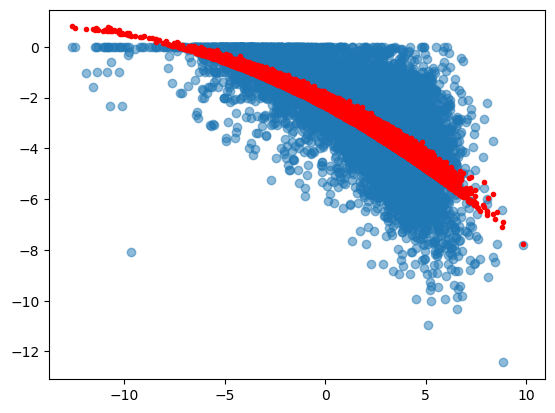

In [230]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

NMD_by_gene['log2_s_score'] = np.log2(NMD_by_gene.post_mean)

x = NMD_by_gene[['RPKM', 'log2_s_score']]

# x = NMD_by_gene.RPKM
y = np.log2(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x))#.reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)
# Plot
plt.scatter(x.RPKM,y, alpha=0.5)
plt.plot(x.RPKM, poly_pred, color='red', linestyle='', marker='.', lw=0.1);


resid = np.array(y) - poly_pred.T[0]
NMD_by_gene['resid'] = resid

In [171]:
X_poly

array([[  4.95694738,  -5.85477635,  24.57132731, -29.02181827,
         34.2784061 ],
       [  2.77819907,  -5.23734238,   7.71839007, -14.55037972,
         27.42975517],
       [  3.65852227,  -9.27937789,  13.38478523, -33.94881069,
         86.10685395],
       ...,
       [  3.48846664,  -4.25398876,  12.16939953, -14.83989788,
         18.09642034],
       [  1.2763747 ,  -7.7706509 ,   1.62913239,  -9.91826225,
         60.38301543],
       [  3.37865179, -10.61773321,  11.41528789, -35.87362326,
        112.73625842]])

In [174]:
-5.85477635**2

-34.27840610851932

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

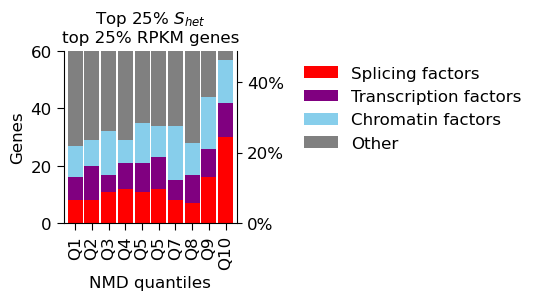

In [178]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1, 'resid') for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,60])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid.png', dpi=300, bbox_inches='tight',)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 8 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'S', 'e', 'h', 'nonmarkingreturn', 'space', 't']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 54, 72, 75, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 8 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', 

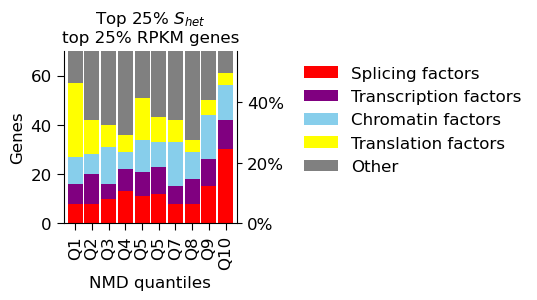

In [259]:
fig, ax = plt.subplots(figsize=(2.24, 2.24))

top_genes = NMD_by_gene.loc[
    (NMD_by_gene.post_mean>NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.RPKM>NMD_by_gene.RPKM.quantile(0.75))]

df = pd.concat([get_slice(top_genes, i, 0.1, 'resid') for i in np.linspace(0.1, 1, 10)], axis=0)
df[['Splicing factors', 'Transcription factors', 'Chromatin factors', 'Translation factors', 'Other']].plot(
    kind='bar', stacked=True, #order = ['Other', 'Transcription factors', 'Chromatin factors', 
                                   #        'Kinases', 'Other RBP', 'Splicing factors'],
        color=['red', 'purple', 'skyblue', 'yellow', 'grey'], ax=ax, width=0.9)
ax.set_title(r'Top 25% $S_{het}$'+'\ntop 25% RPKM genes', size=12)
ax.legend(frameon=False, bbox_to_anchor=(1.3, 1), fontsize=12)
ax.tick_params(length=5, labelsize=12)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim([0,70])

ax.set_xlabel('NMD quantiles', size=12)
ax.set_ylabel('Genes', size=12)

y = ax.secondary_yaxis('right')
y.set_ticks([0, 24.6, 49.2], ['0%', '20%', '40%'], fontsize=12)
figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_SF_NMD_barplot_resid.png', dpi=300, bbox_inches='tight',)

2023-08-16 17:08:41,366 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-16 17:08:41,543 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-16 17:08:45,324 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-16 17:08:51,413 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'I', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'a', 'd', 'e', 'four', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'p', 'r', 's', 'space', 't']
INFO:f

INFO:fontTools.subset:Closing glyph list over 'glyf': 39 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 60, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 39 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'Y', 'e', 'five', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 24, 36, 37, 38

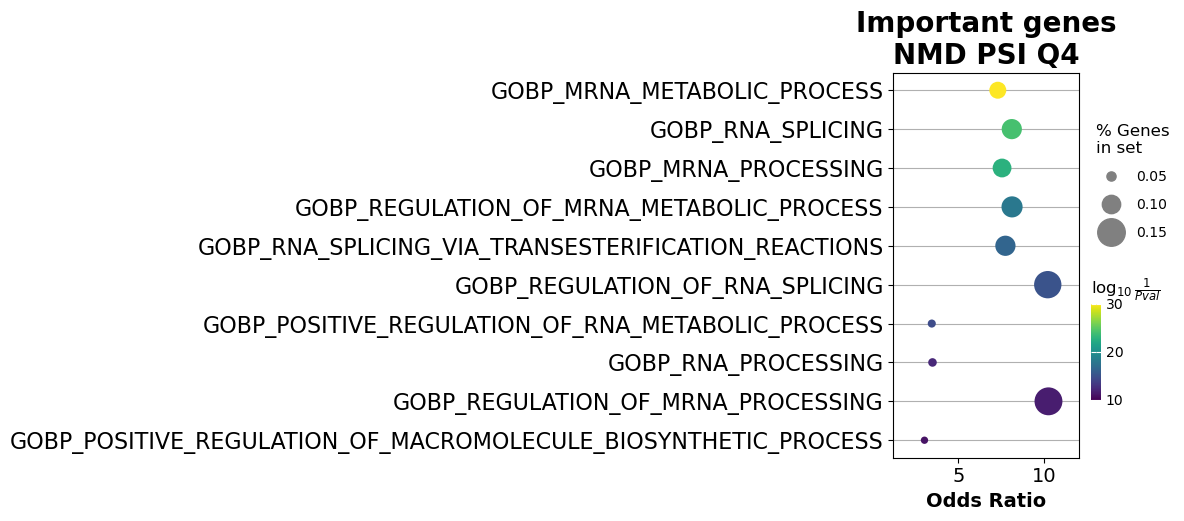

In [251]:
import gseapy as gp
from gseapy import barplot, dotplot

gene_list = list(top_genes.loc[top_genes.PSI > top_genes.PSI.quantile(0.75)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q4',cmap='viridis', size=22, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

In [252]:
top_genes

,gene,symbol,PSI,junc_counts,NMD_counts,NMD_percent,RPKM,Rank 1,Rank 2,Rank 3,...,obs_lof,exp_lof,prior_mean,post_mean,post_lower_95,post_upper_95,resid,log2_s_score,exon_count,Percent_NMD_transcripts
12,ENSG00000001629,ANKIB1,0.117574,307196,11895,0.038721,4.695919,0.275074,0.147793,0.119462,...,5.0,50.7010,0.133392,0.139116,0.072880,0.236615,1.497355,-2.845645,20,0.546072
20,ENSG00000002834,LASP1,0.012573,127718,370,0.002897,4.603351,0.618919,0.381081,0.000000,...,1.0,16.7620,0.206829,0.226879,0.067217,0.512412,-1.743120,-2.140003,15,0.042585
27,ENSG00000003402,CFLAR,0.042033,413783,8947,0.021622,4.931664,0.311389,0.231921,0.192579,...,1.0,27.3950,0.120694,0.195856,0.076003,0.398876,0.164325,-2.352131,20,0.354153
29,ENSG00000003756,RBM5,0.082044,876169,15516,0.017709,5.353884,0.347706,0.324246,0.230665,...,3.0,57.4580,0.297465,0.506809,0.235524,0.799291,1.422881,-0.980485,25,0.360258
37,ENSG00000004487,KDM1A,0.080166,270994,1850,0.006827,4.395523,1.000000,0.000000,0.000000,...,7.0,47.6580,0.269087,0.123556,0.062947,0.216642,0.777568,-3.016759,19,0.122038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11197,ENSG00000255302,EID1,0.814103,812,382,0.470443,4.469488,1.000000,0.000000,0.000000,...,1.0,5.3208,0.083280,0.068643,0.002327,0.237139,4.115130,-3.864737,1,0.470443
11215,ENSG00000257103,LSM14A,0.019681,97989,81,0.000827,4.621922,0.790123,0.209877,0.000000,...,7.0,23.9100,0.345573,0.082896,0.036788,0.160094,-1.160098,-3.592555,10,0.008236
11276,ENSG00000270647,TAF15,0.023816,340869,2032,0.005961,4.692350,0.472441,0.407480,0.081693,...,11.0,45.7210,0.164273,0.074172,0.043176,0.118328,-0.856829,-3.752988,16,0.091232
11279,ENSG00000272333,KMT2B,0.022280,681886,3263,0.004785,4.796632,0.235673,0.155072,0.150475,...,3.0,111.4600,0.349418,0.522362,0.295326,0.765649,-0.762859,-0.936878,37,0.162622


2023-08-16 14:17:06,164 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-16 14:17:06,409 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-16 14:17:10,234 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-16 14:17:17,785 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'D', 'I', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'a', 'd', 'e', 'g', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't']
INFO:fo

INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'e', 'eight', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 25, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 44 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 

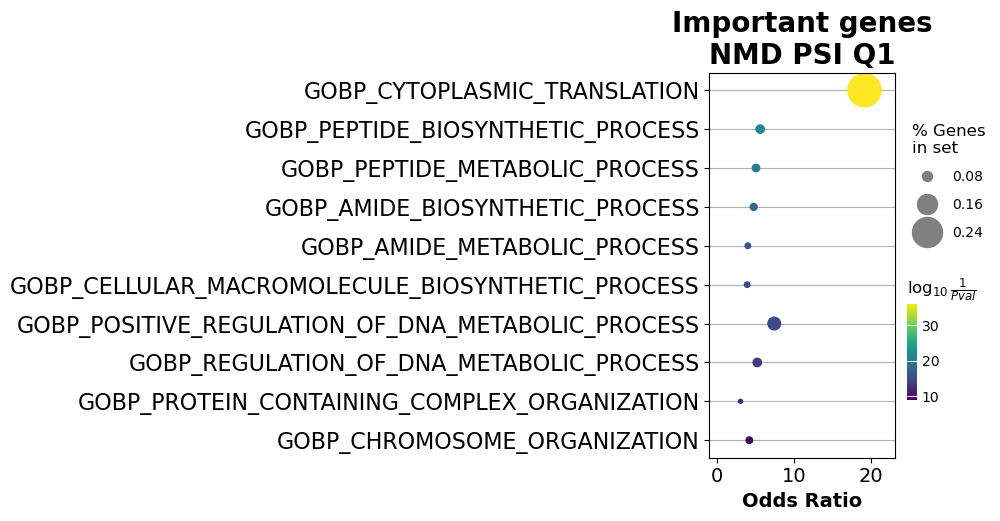

In [128]:
import gseapy as gp
from gseapy import barplot, dotplot

gene_list = list(top_genes.loc[top_genes.PSI < top_genes.PSI.quantile(0.25)].symbol)
# gene_list = list(NMD_by_gene.loc[NMD_by_gene.resid > NMD_by_gene.resid.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='Important genes\nNMD PSI Q1',cmap='viridis', size=15, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_important_genes_NMD_Q1.png', dpi=300, bbox_inches='tight',)

2023-08-16 14:20:41,637 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-16 14:20:41,934 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-16 14:20:45,727 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-16 14:20:59,178 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'Q', 'R', 'T', 'a', 'd', 'e', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'space', 't']
INFO:fontTools.su

INFO:fontTools.subset:Closing glyph list over 'glyf': 41 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 36, 37, 38, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 53, 54, 55, 56, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 41 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'space', 't', 'three', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 

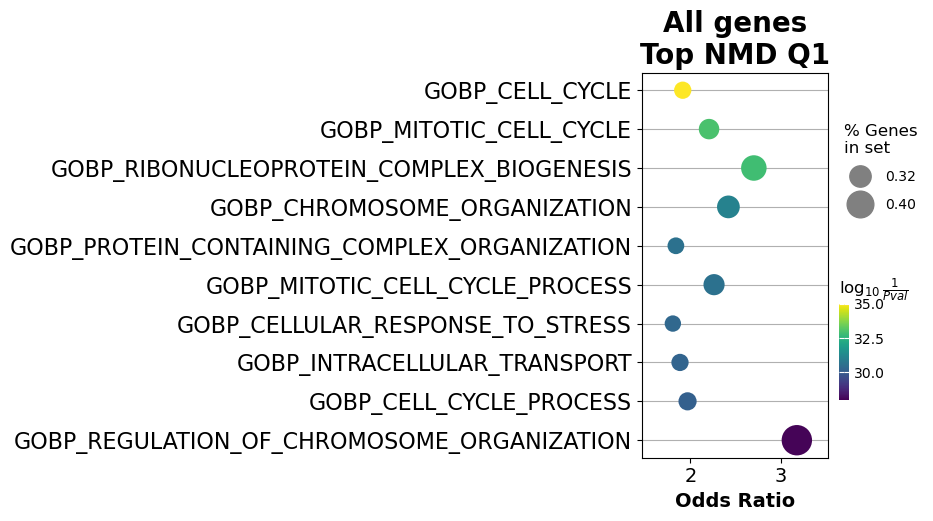

In [130]:
# gene_list = list(NMD_by_gene.sort_values('PSI').symbol)[-200:]
gene_list = list(NMD_by_gene.loc[NMD_by_gene.PSI < NMD_by_gene.PSI.quantile(0.25)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop NMD Q1',cmap='viridis', size=8, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q1.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q1.png', dpi=300, bbox_inches='tight',)

2023-08-16 17:07:05,337 [INFO] User defined gene sets is given: ../../c5.go.bp.v2023.1.Hs.symbols.gmt
2023-08-16 17:07:05,597 [INFO] Run: c5.go.bp.v2023.1.Hs.symbols.gmt 
2023-08-16 17:07:09,430 [INFO] Background is not set! Use all 17890 genes in c5.go.bp.v2023.1.Hs.symbols.gmt.
2023-08-16 17:07:22,024 [INFO] Done.
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 24 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'D', 'M', 'N', 'O', 'Q', 'R', 'T', 'a', 'd', 'e', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'p', 's', 'space', 't']
INFO:fontTools.s

INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closing glyph list over 'glyf': 44 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'e', 'five', 'four', 'g', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'six', 'space', 't', 'two', 'underscore', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 23, 24, 25, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 66, 72, 74, 76, 79, 81, 82, 86, 87]
INFO:fontTools.subset:Closed glyph list over 'glyf': 44 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 

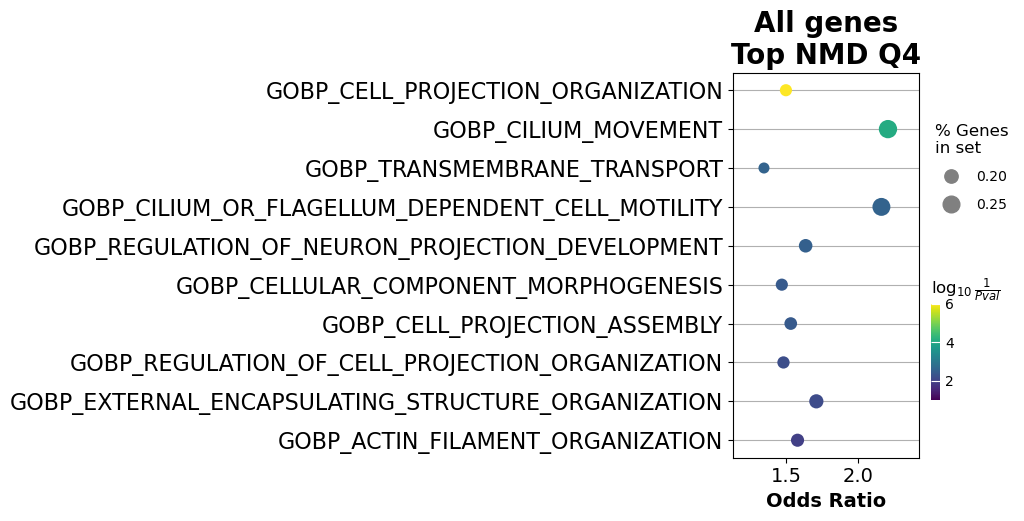

In [250]:
# gene_list = list(NMD_by_gene.sort_values('PSI').symbol)[-200:]
gene_list = list(NMD_by_gene.loc[NMD_by_gene.PSI > NMD_by_gene.PSI.quantile(0.75)].symbol)

enr2 = gp.enrich(gene_list=gene_list, # or gene_list=glist
                 gene_sets=['../../c5.go.bp.v2023.1.Hs.symbols.gmt'], # kegg is a dict object
                 background=None, #"hsapiens_gene_ensembl",
                 outdir=None,
                 verbose=True)

dotplot(enr2.res2d, title='All genes\nTop NMD Q4',cmap='viridis', size=8, figsize=(3,5))
# plt.savefig(figdir + 'supplementary_figures/NMD_Q4_MSigDB_C5.pdf', dpi=300, bbox_inches='tight')
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q4.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_GO_all_genes_NMD_Q4.png', dpi=300, bbox_inches='tight',)

<Axes: >

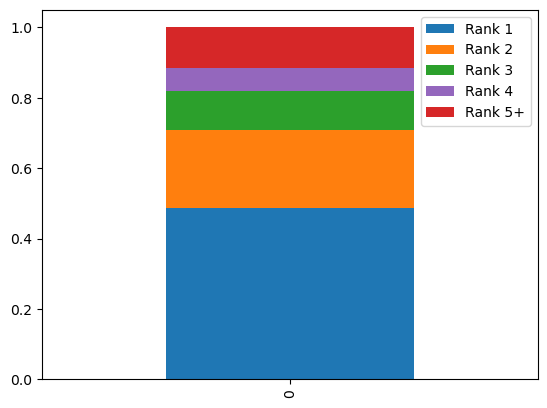

In [137]:
df_bar = pd.DataFrame()
df_bar['All genes'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx), 
                                             ranks].mean(axis=0)

df_bar['Splicing factors'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Splicing factors'), 
                                             ranks].mean(axis=0)
df_bar['Transcription factors'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Transcription factors'), 
                                             ranks].mean(axis=0)
df_bar['Chromatin factors'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Chromatin factors'), 
                                             ranks].mean(axis=0)
df_bar['Other'] = NMD_by_gene.loc[NMD_by_gene.gene.isin(entropy_idx) & (NMD_by_gene.annotation=='Other'), 
                                             ranks].mean(axis=0)

<Axes: >

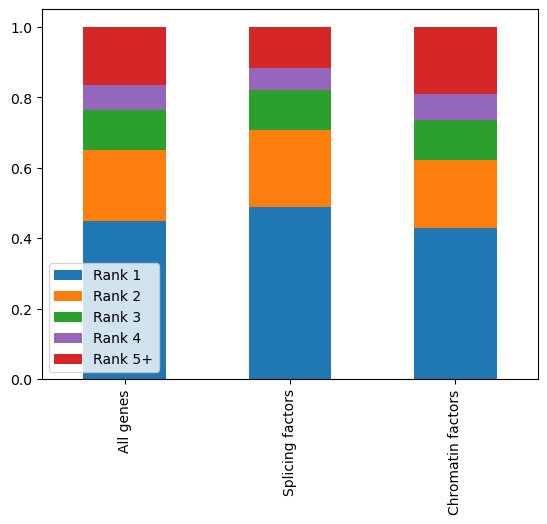

In [142]:
df_bar[['All genes', 'Splicing factors', 'Chromatin factors']
      ].T.plot(kind='bar', stacked=True, color=['tab:blue', 'tab:orange', 'tab:green', 
                                                                            'tab:purple', 'tab:red'])


In [13]:
long_table

,chrom,start,stop,strand,Dataset,IndID,RepNumber,Count,end,NewAnnotation,gene,symbol,SuperAnnotation,SemiSupergroupAnnotations,junction,gene_total,gene_max,PSI_total,PSI
9737,chr1,944800,945042,-,chRNA.Expression.Splicing,NA18853,1.junc,36,945042,retained_intron.gencode,ENSG00000188976,NOC2L,AnnotatedJunc_UnproductiveCodingGene,uniquely retained_intron tag,chr1:944800:945042:-,4149,486,0.008677,0.074074
9738,chr1,944800,945057,-,chRNA.Expression.Splicing,NA18853,1.junc,115,945057,protein_coding.gencode,ENSG00000188976,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,chr1:944800:945057:-,4149,486,0.027718,0.236626
9739,chr1,945146,945518,-,chRNA.Expression.Splicing,NA18853,1.junc,231,945518,protein_coding.gencode,ENSG00000188976,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,chr1:945146:945518:-,4149,486,0.055676,0.475309
9740,chr1,945653,946173,-,chRNA.Expression.Splicing,NA18853,1.junc,115,946173,protein_coding.gencode,ENSG00000188976,NOC2L,AnnotatedJunc_ProductiveCodingGene,basic tag,chr1:945653:946173:-,4149,486,0.027718,0.236626
9741,chr1,945653,946147,-,chRNA.Expression.Splicing,NA18853,1.junc,4,946147,nonsense_mediated_decay.pstopcodon,ENSG00000188976,NOC2L,UnannotatedJunc_UnproductiveCodingGene,predicted_NMD pstopcodon,chr1:945653:946147:-,4149,486,0.000964,0.008230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15988530,chr12,117285332,117286104,-,chRNA.Expression.Splicing,NA19128,1.junc,2,117286104,protein_coding.gencode,ENSG00000089250,NOS1,AnnotatedJunc_ProductiveCodingGene,basic tag,chr12:117285332:117286104:-,2,2,1.000000,1.000000
15988536,chr15,100341409,100341821,-,chRNA.Expression.Splicing,NA19128,1.junc,2,100341821,protein_coding.gencode,ENSG00000140470,ADAMTS17,AnnotatedJunc_ProductiveCodingGene,basic tag,chr15:100341409:100341821:-,2,2,1.000000,1.000000
15988538,chr16,23700704,23702152,-,chRNA.Expression.Splicing,NA19128,1.junc,2,23702152,protein_coding.gencode,ENSG00000134398,ERN2,AnnotatedJunc_ProductiveCodingGene,basic tag,chr16:23700704:23702152:-,2,2,1.000000,1.000000
15988539,chr16,70941819,70943812,-,chRNA.Expression.Splicing,NA19128,1.junc,4,70943812,protein_coding.gencode,ENSG00000157423,HYDIN,AnnotatedJunc_ProductiveCodingGene,basic tag,chr16:70941819:70943812:-,6,4,0.666667,1.000000


In [80]:
NMD_by_gene

,gene,symbol,PSI,junc_counts,NMD_counts,NMD_percent,RPKM,Rank 1,Rank 2,Rank 3,...,NMD_transcripts,annotation,hgnc,chrom,obs_lof,exp_lof,prior_mean,post_mean,post_lower_95,post_upper_95
0,ENSG00000000419,DPM1,0.027426,136973,948,0.006921,4.956947,0.506329,0.450422,0.043249,...,5.704358,Other,HGNC:3005,chr20,9.0,17.9800,0.015030,0.017280,0.002883,0.038134
1,ENSG00000000457,SCYL3,0.067388,63919,3531,0.055242,2.778199,0.221184,0.144435,0.138204,...,1.586403,Other,HGNC:19285,chr1,8.0,34.3200,0.009598,0.026510,0.008297,0.048808
2,ENSG00000000460,C1orf112,0.116244,218780,7421,0.033920,3.658522,0.273279,0.146880,0.096752,...,6.599619,Other,HGNC:25565,chr1,23.0,44.6360,0.003274,0.001609,0.000180,0.004741
3,ENSG00000000938,FGR,0.117739,405076,12244,0.030226,5.817197,0.499020,0.171839,0.147174,...,57.885502,Other,HGNC:3697,chr1,6.0,27.8370,0.033294,0.043014,0.019917,0.075332
4,ENSG00000001036,FUCA2,0.051398,29746,163,0.005480,3.147563,0.760736,0.239264,0.000000,...,1.750591,Other,HGNC:4008,chr6,14.0,24.2610,0.001359,0.000902,0.000036,0.003496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,ENSG00000280789,PAGR1,0.036527,11708,39,0.003331,2.398451,1.000000,0.000000,0.000000,...,0.588188,Chromatin factors,HGNC:28707,chr16,1.0,8.8160,0.028018,0.165779,0.007167,0.531561
11546,ENSG00000282988,AL031777.2,0.833333,468,226,0.482906,1.041698,0.725664,0.230088,0.044248,...,3.455378,Other,HGNC:4767,chr6,4.0,3.4746,0.020204,0.002177,0.000021,0.009345
11554,ENSG00000284024,AC069544.1,0.391197,9600,1653,0.172187,3.488467,1.000000,0.000000,0.000000,...,18.736599,Other,HGNC:29526,chr10,6.0,29.9440,0.039154,0.052411,0.026162,0.090981
11562,ENSG00000284770,TBCE,0.083500,85408,1832,0.021450,1.276375,0.388646,0.186135,0.174672,...,0.437804,Other,HGNC:11582,chr1,18.0,33.1770,0.004361,0.004579,0.000508,0.013568


In [20]:
long_long_table.loc[long_table.SuperAnnotation.isin(NMD)].groupby(['gene', 'symbol', 'junction']
                                                            )[['PSI_total', 'PSI']].mean().reset_index()

,gene,symbol,junction,PSI_total,PSI
0,ENSG00000000419,DPM1,chr20:50940955:50941105:-,0.001552,0.010028
1,ENSG00000000419,DPM1,chr20:50940955:50942031:-,0.004361,0.027426
2,ENSG00000000419,DPM1,chr20:50942126:50945847:-,0.004114,0.026221
3,ENSG00000000457,SCYL3,chr1:169855857:169859041:-,0.002871,0.015766
4,ENSG00000000457,SCYL3,chr1:169855932:169859041:-,0.003798,0.017665
...,...,...,...,...,...
87483,ENSG00000286905,AC108488.2,chr2:3536911:3545701:-,0.670479,0.916566
87484,ENSG00000287725,AP003071.5,chr11:69088366:69135435:+,0.805556,0.916667
87485,ENSG00000287725,AP003071.5,chr11:69135532:69159446:+,0.953704,1.000000
87486,ENSG00000288534,AP001931.2,chr11:57712807:57789037:+,0.383838,0.431250


In [21]:
long_summary

,gene,junction,Count,exon_count
0,ENSG00000000419,chr20:50940955:50941105:-,41,9
1,ENSG00000000419,chr20:50940955:50942031:-,427,9
2,ENSG00000000419,chr20:50942126:50945847:-,480,9
3,ENSG00000000457,chr1:169855857:169859041:-,47,14
4,ENSG00000000457,chr1:169855932:169859041:-,13,14
...,...,...,...,...
87483,ENSG00000286905,chr2:3536911:3545701:-,576,12
87484,ENSG00000287725,chr11:69088366:69135435:+,9,15
87485,ENSG00000287725,chr11:69135532:69159446:+,45,15
87486,ENSG00000288534,chr11:57712807:57789037:+,8,21


In [23]:
long_summary

,gene,junction,Count
0,ENSG00000000419,chr20:50940955:50941105:-,41
1,ENSG00000000419,chr20:50940955:50942031:-,427
2,ENSG00000000419,chr20:50942126:50945847:-,480
3,ENSG00000000457,chr1:169855857:169859041:-,47
4,ENSG00000000457,chr1:169855932:169859041:-,13
...,...,...,...
87483,ENSG00000286905,chr2:3536911:3545701:-,576
87484,ENSG00000287725,chr11:69088366:69135435:+,9
87485,ENSG00000287725,chr11:69135532:69159446:+,45
87486,ENSG00000288534,chr11:57712807:57789037:+,8


In [43]:
long_table.Count

9737        0.074074
9738        0.236626
9739        0.475309
9740        0.236626
9741        0.008230
              ...   
15988530    1.000000
15988536    1.000000
15988538    1.000000
15988539    1.000000
15988540    0.500000
Length: 14883790, dtype: float64

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'a', 'c', 'e', 'five', 'four', 'g', 'i', 'j', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 36, 37, 38, 39, 41, 44, 46, 47, 48, 49, 51, 53, 54, 68, 70, 72, 74, 76, 77, 79, 81, 82, 86, 87, 88, 91, 3228]
INFO:

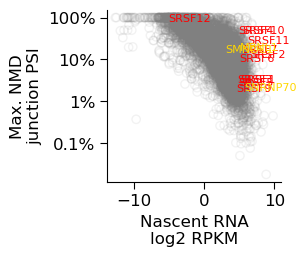

In [207]:
genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)

other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)


x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(x,y, facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].RPKM, 
#                np.log10(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].PSI))

# resid = np.array(y) - poly_pred.T[0]
# NMD_by_gene['resid'] = resid

for sr_gene in srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='red', fontsize=8)
    
for sr_gene in other_sf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='gold', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_yticks([-3, -2, -1, 0])
ax.set_yticklabels(['0.1%', '1%', '10%', '100%'])

ax.set_xlabel('Nascent RNA\nlog2 RPKM', size=12)
ax.set_ylabel('Max. NMD\njunction PSI', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.png', dpi=300, bbox_inches='tight',)

In [187]:
NMD_by_gene = NMD_by_gene.merge(exon_counts.groupby('gene').exon_count.sum().reset_index(), left_on='gene', right_on='gene')

In [191]:
1-(NMD_by_gene.NMD_percent**NMD_by_gene.exon_count)

0        1.000000
1        1.000000
2        1.000000
3        1.000000
4        1.000000
           ...   
11303    1.000000
11304    0.766802
11305    0.999121
11306    1.000000
11307    1.000000
Length: 11308, dtype: float64

In [231]:
NMD_by_gene.loc[NMD_by_gene.symbol.isin(other_sf + srsf), ['gene', 'symbol', 'resid']]

,gene,symbol,resid
1711,ENSG00000100650,SRSF5,-0.074554
2093,ENSG00000104852,SNRNP70,0.031570
2778,ENSG00000111786,SRSF9,-0.745453
2812,ENSG00000112081,SRSF3,0.195261
3163,ENSG00000115875,SRSF7,2.883147
3220,ENSG00000116350,SRSF4,4.054554
3264,ENSG00000116754,SRSF11,4.049261
3537,ENSG00000119953,SMNDC1,1.513236
3840,ENSG00000124193,SRSF6,1.854061
5004,ENSG00000136450,SRSF1,0.395333


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'a', 'c', 'e', 'five', 'four', 'g', 'i', 'j', 'l', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'percent', 'period', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 36, 37, 38, 39, 41, 44, 46, 47, 48, 49, 51, 53, 54, 68, 70, 72, 74, 76, 77, 79, 81, 82, 86, 87, 88, 91, 3228]
INFO:

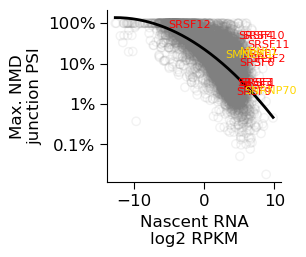

In [228]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

NMD_by_gene['log2_s_score'] = np.log2(NMD_by_gene.post_mean)

x = NMD_by_gene[['RPKM', 'log2_s_score']]

x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly2.fit_transform(np.array(x).reshape(-1, 1))
# Fit Linear model with poly features
poly_model = LinearRegression().fit(X_poly,np.array(y).reshape(-1, 1))
poly_pred = poly_model.predict(X_poly)


genes = pd.read_csv('../../genes.txt', sep='\t', names=['genes'], index_col=0)
genes.index = [x.split('.')[0] for x in genes.index]

srsf = ['SRSF'+str(x) for x in range(13)]
srsf_ensembl = genes.loc[genes.genes.isin(srsf)].index.intersection(RPKM.index)

other_sf = ['MBNL1', 'SNRNP70', 'SMNDC1']
other_sf_ensembl = genes.loc[genes.genes.isin(other_sf)].index.intersection(RPKM.index)


x = NMD_by_gene.RPKM
y = np.log10(NMD_by_gene.PSI)

fig, ax = plt.subplots(figsize=(2.24, 2.24))

ax.scatter(x,y, facecolor='none', edgecolor='grey', alpha=0.1)

# ax.scatter(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].RPKM, 
#                np.log10(NMD_by_gene.loc[NMD_by_gene.gene.isin(srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)))].PSI))

# resid = np.array(y) - poly_pred.T[0]
# NMD_by_gene['resid'] = resid

for sr_gene in srsf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='red', fontsize=8)
    
for sr_gene in other_sf_ensembl.intersection(pd.Index(NMD_by_gene.gene)):
    ax.annotate(genes.loc[sr_gene].genes, (NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].RPKM-0.5, 
               np.log10(NMD_by_gene.loc[NMD_by_gene.gene==sr_gene].PSI)-0.1), c='gold', fontsize=8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

df_pred = pd.DataFrame()
df_pred['x'] = list(x)
df_pred['y'] = [y[0] for y in poly_pred]

ax.plot(df_pred.sort_values('x').x, df_pred.sort_values('x').y, color='black', lw=2)


ax.set_yticks([-3, -2, -1, 0])
ax.set_yticklabels(['0.1%', '1%', '10%', '100%'])

ax.set_xlabel('Nascent RNA\nlog2 RPKM', size=12)
ax.set_ylabel('Max. NMD\njunction PSI', size=12)

ax.tick_params(length=5, labelsize=12)

figdir = '/project2/yangili1/carlos_and_ben_shared/polished_plots/'

plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.pdf', dpi=300, bbox_inches='tight',)
plt.savefig(figdir + 'Supp_RPKM_vs_NMD_PSI_scatter.png', dpi=300, bbox_inches='tight',)

In [243]:
NMD_by_gene['z_resid'] = zscore(NMD_by_gene.resid)
NMD_by_gene.loc[NMD_by_gene.symbol.isin(other_sf + srsf), ['gene', 'symbol', 'resid', 'z_resid']]

,gene,symbol,resid,z_resid
1711,ENSG00000100650,SRSF5,-0.074554,-0.060258
2093,ENSG00000104852,SNRNP70,0.031570,0.025516
2778,ENSG00000111786,SRSF9,-0.745453,-0.602505
2812,ENSG00000112081,SRSF3,0.195261,0.157818
3163,ENSG00000115875,SRSF7,2.883147,2.330278
3220,ENSG00000116350,SRSF4,4.054554,3.277056
3264,ENSG00000116754,SRSF11,4.049261,3.272779
3537,ENSG00000119953,SMNDC1,1.513236,1.223059
3840,ENSG00000124193,SRSF6,1.854061,1.498528
5004,ENSG00000136450,SRSF1,0.395333,0.319525


In [247]:
NMD_by_gene.z_resid

1.0000442194167674

In [244]:
NMD_by_gene.sort_values('z_resid')

,gene,symbol,PSI,junc_counts,NMD_counts,NMD_percent,RPKM,Rank 1,Rank 2,Rank 3,...,exp_lof,prior_mean,post_mean,post_lower_95,post_upper_95,resid,log2_s_score,exon_count,Percent_NMD_transcripts,z_resid
10947,ENSG00000215472,RPL17-C18orf32,0.003731,289891,175,6.036752e-04,-9.635229,0.388571,0.354286,0.257143,...,15.5900,0.087558,0.057253,0.008636,0.181795,-8.491486,-4.126501,7,0.004218,-6.863166
10396,ENSG00000197756,RPL37A,0.000506,484826,6,1.237557e-05,5.099814,0.833333,0.166667,0.000000,...,5.9746,0.129593,0.020768,0.001292,0.083270,-6.313630,-5.589507,4,0.000050,-5.102934
6081,ENSG00000146701,MDH2,0.001032,244566,3,1.226663e-05,4.521274,1.000000,0.000000,0.000000,...,14.6780,0.011424,0.010399,0.000565,0.030659,-5.659974,-6.587441,9,0.000110,-4.574622
2747,ENSG00000111640,GAPDH,0.000181,3720119,2,5.376172e-07,8.821009,1.000000,0.000000,0.000000,...,13.7180,0.097212,0.055017,0.016485,0.120571,-5.533767,-4.183987,26,0.000014,-4.472617
10955,ENSG00000216490,IFI30,0.002685,377594,80,2.118678e-04,2.857504,0.600000,0.162500,0.125000,...,12.7810,0.000972,0.000414,0.000011,0.001671,-5.473440,-11.237071,7,0.001482,-4.423858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,ENSG00000156976,EIF4A2,0.578559,527237,88762,1.683531e-01,6.192875,0.477006,0.298348,0.104065,...,23.0920,0.476652,0.506841,0.157960,0.882604,4.720423,-0.980396,11,0.868378,3.815239
7832,ENSG00000166012,TAF1D,0.897546,659247,409637,6.213710e-01,5.842360,0.165161,0.143517,0.135845,...,11.6480,0.017096,0.023568,0.000995,0.080787,4.891662,-5.407045,6,0.997054,3.953641
10317,ENSG00000197153,H3C12,1.000000,3,3,1.000000e+00,6.044392,1.000000,0.000000,0.000000,...,2.9300,0.010540,0.010560,0.000075,0.045065,5.069146,-6.565281,1,1.000000,4.097091
206,ENSG00000011590,ZBTB32,1.000000,104530,49596,4.744667e-01,5.916089,0.962416,0.020707,0.011271,...,19.1880,0.045504,0.116538,0.010631,0.351085,5.240466,-3.101131,13,0.999767,4.235559


In [249]:
NMD_by_gene.loc[(NMD_by_gene.post_mean > NMD_by_gene.post_mean.quantile(0.75)) & (NMD_by_gene.symbol.isin(other_sf + srsf))]

,gene,symbol,PSI,junc_counts,NMD_counts,NMD_percent,RPKM,Rank 1,Rank 2,Rank 3,...,exp_lof,prior_mean,post_mean,post_lower_95,post_upper_95,resid,log2_s_score,exon_count,Percent_NMD_transcripts,z_resid
1711,ENSG00000100650,SRSF5,0.029484,470548,4061,0.008630,5.418160,0.714602,0.227530,0.057868,...,16.9510,0.324941,0.210584,0.062682,0.461476,-0.074554,-2.247529,25,0.194825,-0.060258
2093,ENSG00000104852,SNRNP70,0.022498,649975,4196,0.006456,6.172447,0.534080,0.400143,0.065777,...,25.2210,0.448500,0.568341,0.196771,0.923034,0.031570,-0.815172,10,0.062713,0.025516
2778,ENSG00000111786,SRSF9,0.021375,91944,663,0.007211,5.027585,0.987934,0.012066,0.000000,...,11.9080,0.268451,0.234189,0.050680,0.629830,-0.745453,-2.094252,4,0.028533,-0.602505
2812,ENSG00000112081,SRSF3,0.035381,316318,4370,0.013815,5.288809,0.578490,0.349657,0.067277,...,10.2870,0.636952,0.708122,0.249514,0.980213,0.195261,-0.497929,12,0.153748,0.157818
3163,ENSG00000115875,SRSF7,0.184946,510559,24832,0.048637,5.885160,0.669499,0.158707,0.076232,...,21.0670,0.554179,0.405139,0.127988,0.811429,2.883147,-1.303513,8,0.328926,2.330278
3220,ENSG00000116350,SRSF4,0.510905,136021,36202,0.266150,5.409326,0.401939,0.270538,0.102867,...,24.2060,0.464432,0.274350,0.103155,0.558216,4.054554,-1.865911,6,0.843813,3.277056
3264,ENSG00000116754,SRSF11,0.303682,1221906,100103,0.081924,6.631781,0.437030,0.153072,0.137418,...,27.0630,0.438709,0.521930,0.201503,0.860099,4.049261,-0.938073,13,0.670827,3.272779
3537,ENSG00000119953,SMNDC1,0.178577,39733,4369,0.109959,3.552722,0.458457,0.289311,0.141680,...,11.8910,0.257506,0.148437,0.032917,0.400745,1.513236,-2.752073,12,0.752873,1.223059
3840,ENSG00000124193,SRSF6,0.109299,352780,12977,0.036785,5.514852,0.837790,0.147183,0.014256,...,20.9980,0.255916,0.171838,0.070790,0.339115,1.854061,-2.540875,6,0.201381,1.498528
5004,ENSG00000136450,SRSF1,0.035131,313786,11417,0.036385,5.674698,0.433739,0.408251,0.098625,...,12.3510,0.547772,0.628204,0.197125,0.956862,0.395333,-0.670696,4,0.137787,0.319525
